In [229]:
import pickle
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
%matplotlib inline
import random

## Read data (top 1000 and 200 FRs, FRS, phenotype bins, strain order)

In [205]:
top1000 = pd.read_csv("../../data/100YeastGenomesCombinedHardMasked.gtet300bps.k300.graph.dot-100YeastGenomesCombinedHardMasked.gtet300bps.fna-a0.8-kp0-sup5-sz1-limit1000.topfrs.txt", header = None)
top1000int = [int(top) for top in top1000[0].values]
top200 = pd.read_csv("../../data/100YeastGenomesCombinedHardMasked.gtet300bps.k300.graph.dot-100YeastGenomesCombinedHardMasked.gtet300bps.fna-a0.8-kp0-sup5-sz1-limit200.topfrs.txt", header = None)
top200int = [int(top) for top in top200[0].values]

file = open("frDf.pkl",'rb')
frdf = pickle.load(file)
file.close()

file = open("clust_memb-include_strain.pkl",'rb')
pheno_clusts = pickle.load(file)
file.close()

pheno = pd.read_csv("../../data/phenotypes-cleaned.tsv",delimiter="\t")
strain_order = [x.lower() for x in pheno['strain']]
strain_order = [x for x in strain_order if x in frdf.index]

origins = pd.read_csv('origins.csv')

frdf200 = frdf[top200int]
frdf1000 = frdf[top1000int]

data = frdf1000

In [206]:
frdf_strains = data.index.values

groundtruth_bins = pheno_clusts[0]
groundtruth_exclusions = pheno_clusts[1]

data = data.reindex(strain_order)

## Cluster and Evaluate

In [207]:
names = ["K-Means", "Agglomerative"]

In [243]:
rows = []
for (idx, column) in enumerate(pheno.drop('strain', axis=1)):
    bins = groundtruth_bins[idx][0:95] # drop last 5 of bins because those strains are not in frdf
    exclusions = (groundtruth_exclusions[idx] == False)[:95] # same as above
    bad_indices = np.where(exclusions == False)[0]
    bins_after_exclusions = [bins[i] for i in range(len(bins)) if i not in bad_indices]
    n_clusters = len(set(bins))
    X = data[exclusions]
    if n_clusters == 1:
        continue
    models = [
        KMeans(n_clusters=n_clusters, random_state=0).fit(X),
        AgglomerativeClustering(n_clusters=n_clusters).fit(X)
        ]
    for name, model in zip(names, models):
        silhouette_score = metrics.silhouette_score(X, model.labels_, metric='euclidean')
        nmi = metrics.cluster.normalized_mutual_info_score(bins_after_exclusions, model.labels_)
        foo = [x for x in set(bins)]
        random_clustering = []
        for i in range(X.shape[0]):
            random_clustering.append(random.choice(foo))
        random_nmi = metrics.cluster.normalized_mutual_info_score(random_clustering, model.labels_)
        rows.append([column, name, silhouette_score, nmi, random_nmi])


results_df = pd.DataFrame(rows, columns = ['Phenotype', 'Clustering_Alg', 'Silhouette_Coef', 'NMI', 'random_NMI'])

In [248]:
results_df[results_df['NMI'] > 0.15]

,Phenotype,Clustering_Alg,Silhouette_Coef,NMI,random_NMI
34,"sporulation-%4-spored,_liquid_KAc25C.txt",K-Means,0.325543,0.235024,0.265251
35,"sporulation-%4-spored,_liquid_KAc25C.txt",Agglomerative,0.338836,0.234274,0.313896
38,"sporulation-%sporulation,_KAc_plates_25C.txt",K-Means,0.316962,0.155541,0.100876
39,"sporulation-%sporulation,_KAc_plates_25C.txt",Agglomerative,0.332671,0.156323,0.108211
57,temperature-sd_39C,Agglomerative,0.357102,0.150446,0.173174


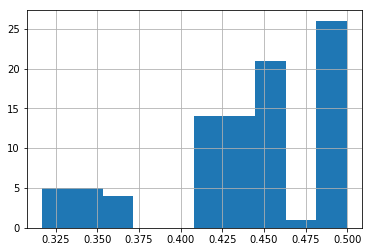

In [252]:
results_df['Silhouette_Coef'].hist()

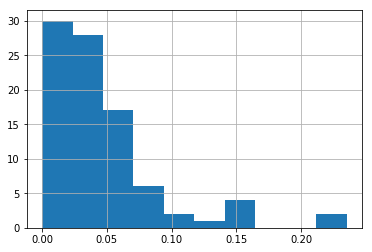

In [250]:
results_df['NMI'].hist()

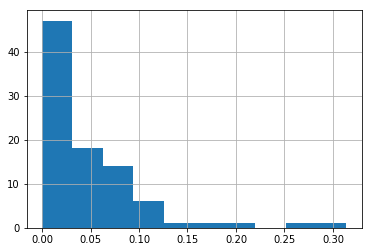

In [249]:
results_df['random_NMI'].hist()

## Make a heatmap of best-performing phenotype

In [267]:
import scipy

In [298]:
labels = model.labels_
X.index = labels
X = X.sort_index()

In [302]:
distances = []
for i in range(X.shape[0]):
    row = []
    p1 = X.iloc[i]
    for j in range(X.shape[0]):
        p2 = X.iloc[j]
        dist_ij = scipy.spatial.distance.pdist(pd.DataFrame([p1, p2]))
        row.append(dist_ij[0])
    distances.append(row)
        

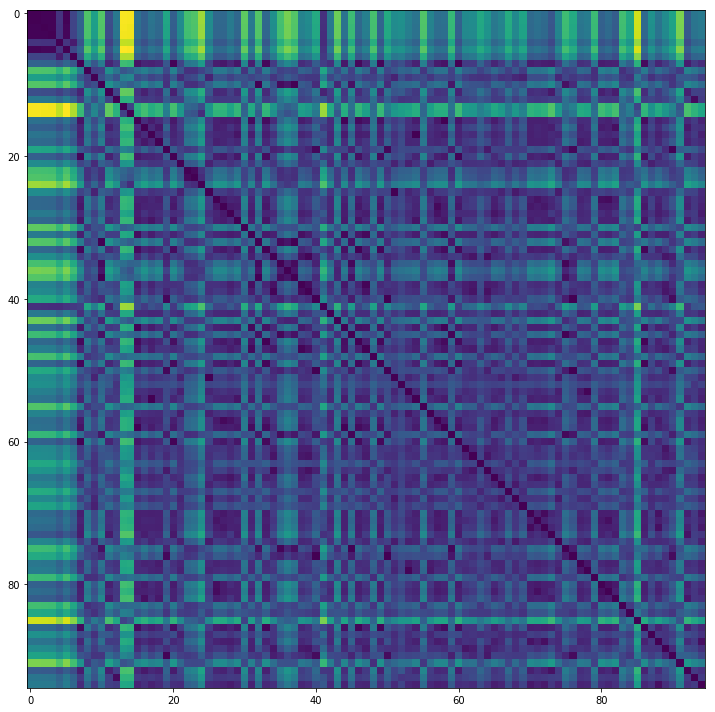

In [305]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(rows)

fig.tight_layout()
plt.show()